# Description

The goal of the project is to analyze a chessboard position given a photo of the board. The algorithm is easily broken into 2 steps:

1. Parse the chess position from the image.
2. Analyze the position to figure out who is winning (along with the best move).

# Imports

In [30]:
import json
import cv2
import chess
import chess.engine
import chess.svg
import matplotlib.pyplot as plt
from IPython.display import SVG, display, HTML
from chesscog.recognition.recognition import ChessRecognizer

# Utilities

In [2]:
def plot_images(images, title=None, save_path=None):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(15, 5), dpi=200)
    if n == 1:
        axes.imshow(images[0])  # Directly use axes as it's a single object
        axes.axis("off")
    else:
        for i in range(n):
            axes[i].imshow(images[i])
            axes[i].axis("off")
    if title is not None:
        fig.suptitle(title, y=0.75)
    if save_path is None:
        plt.show()
        plt.close()
    else:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
        plt.close()

# Parse image of the test set (synthetic)

On the first step we parse an image using an open-source chess image parser. I chose this one:

https://github.com/georg-wolflein/chesscog

First, I pick an image from the test set of the model. The dataset was synthetically generated from a 3D model.

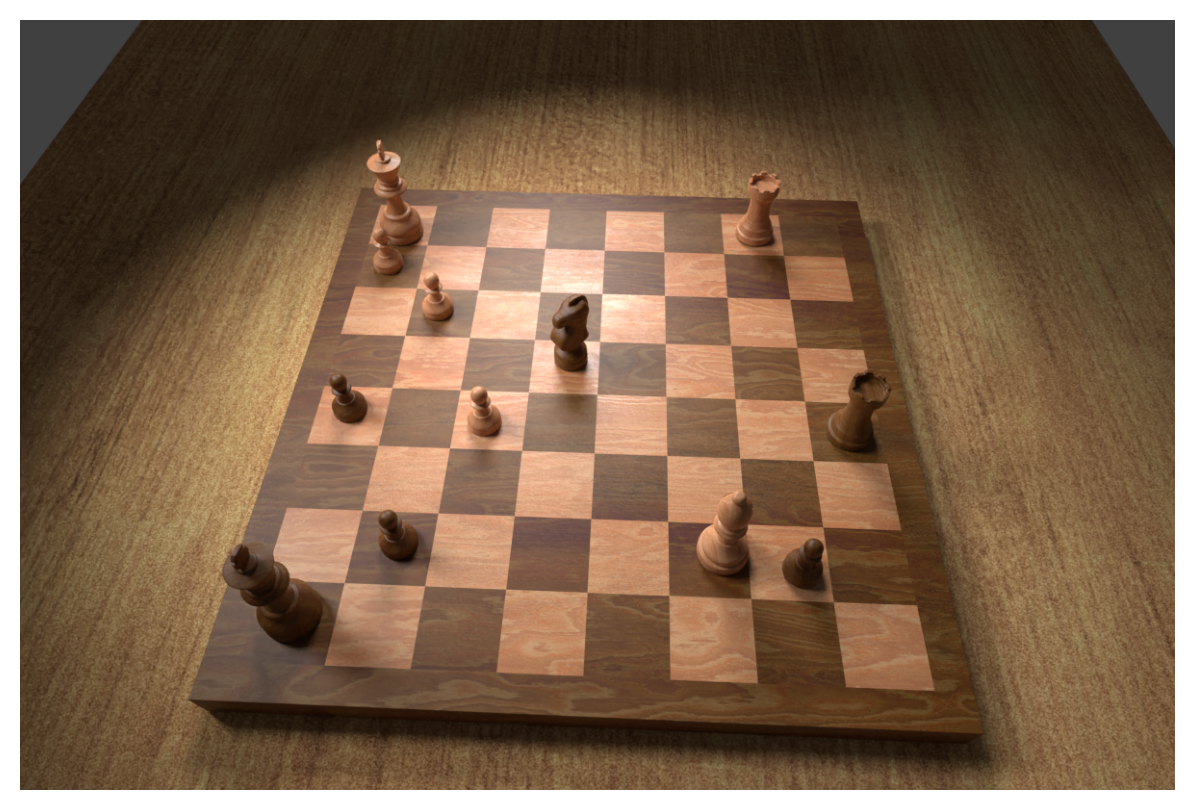

In [3]:
image_path = "./data/render/test/1369.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_images([image])

Read the metadata.

In [4]:
json_path = image_path.replace(".png", ".json")
with open(json_path, "r") as f:
    image_info = json.load(f)
print(image_info)

if image_info["white_turn"]:
    turn = chess.WHITE
    print("It is White's turn to move.")
else:
    turn = chess.BLACK
    print("It is Black's turn to move.")

{'fen': '7k/1pB3p1/8/r4P1p/4n3/6P1/7P/1R5K', 'white_turn': False, 'camera': {'angle': 54, 'location': [-0.00950832199305296, 0.23276296257972717, 0.32037073373794556]}, 'lighting': {'mode': 'spotlights', 'flash': {'active': False}, 'spot1': {'active': True, 'xy_angle': 281, 'focus': [0.21013325452804565, -0.35159698128700256, 0.0], 'location': [0.06869123876094818, -0.3533857762813568, 0.3338702917098999]}, 'spot2': {'active': True, 'xy_angle': 351, 'focus': [0.24485698342323303, -0.08760671317577362, 0.0], 'location': [0.3555678129196167, -0.05631640926003456, 0.35173267126083374]}}, 'corners': [[848, 205], [951, 697], [228, 667], [375, 192]], 'pieces': [{'piece': 'k', 'square': 'h8', 'box': [210, 543, 104, 104]}, {'piece': 'p', 'square': 'g7', 'box': [372, 509, 42, 52]}, {'piece': 'B', 'square': 'c7', 'box': [703, 489, 59, 88]}, {'piece': 'p', 'square': 'b7', 'box': [792, 538, 43, 52]}, {'piece': 'p', 'square': 'h5', 'box': [321, 367, 40, 52]}, {'piece': 'P', 'square': 'f5', 'box': [

In [5]:
chessboard_parser = ChessRecognizer()
board, _ = chessboard_parser.predict(image, turn)

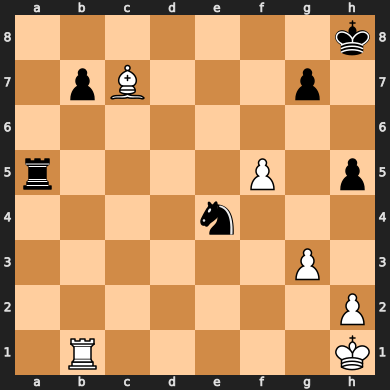

In [27]:
board

As we can see, the board was parsed 100% correctly!

In [26]:
str(board)

'. . . . . . . k\n. p B . . . p .\n. . . . . . . .\nr . . . . P . p\n. . . . n . . .\n. . . . . . P .\n. . . . . . . P\n. R . . . . . K'

# Parse custom image

Let's try loading a custom image, and see what happens.

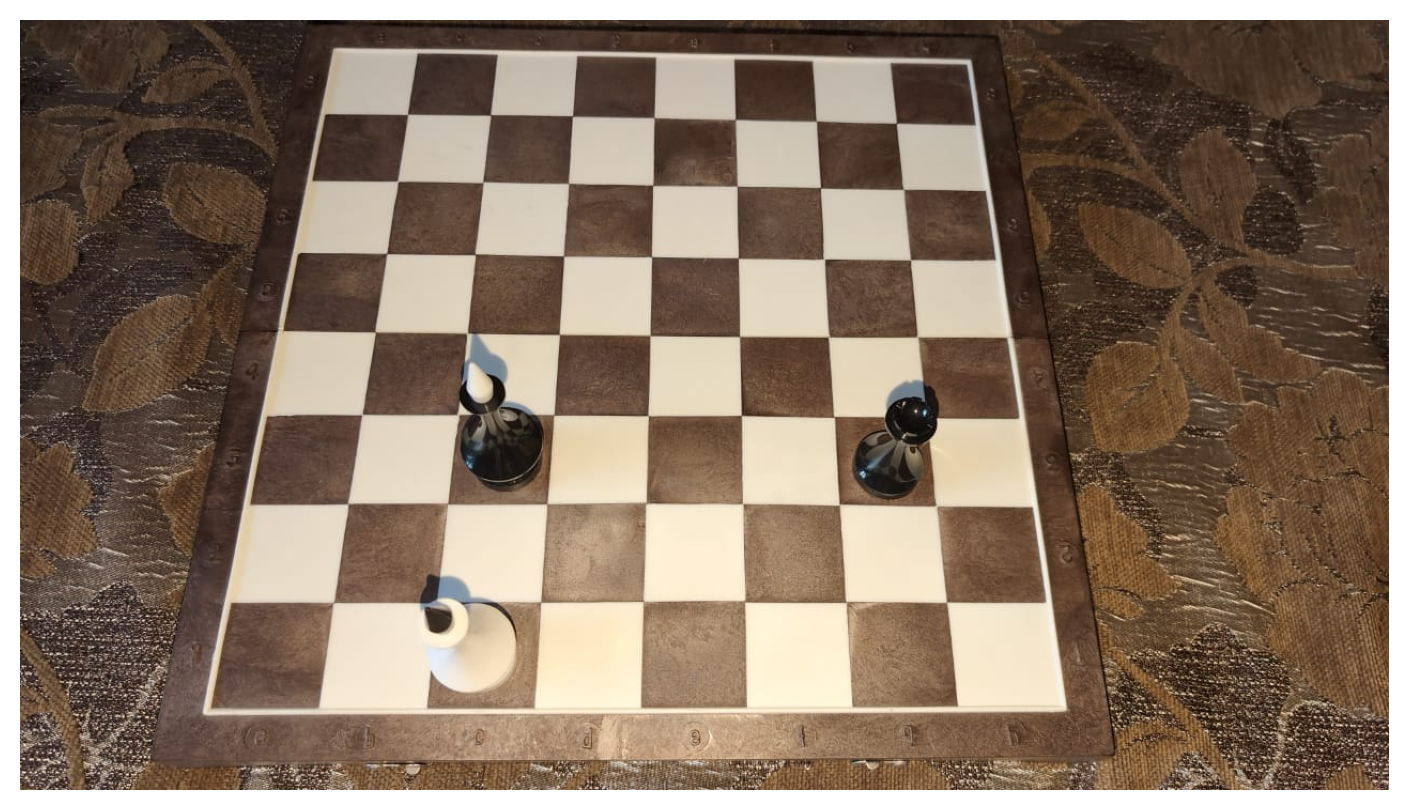

In [23]:
custom_image_path = "../assets/custom_image.jpeg"
custom_image = cv2.imread(custom_image_path)
custom_image = cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB)
custom_image = cv2.rotate(custom_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
plot_images([custom_image])

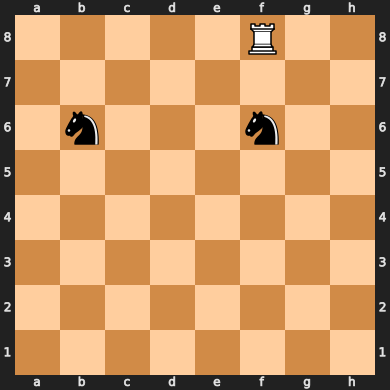

In [25]:
chessboard_parser = ChessRecognizer()
custom_board, _ = chessboard_parser.predict(custom_image, chess.BLACK)
custom_board

The image was not parsed correcly at all. The model clearly requires fine-tuning for custom boards.

# Analysis of the position using a chess engine

Let's analyze the board using an open-source chess enigine. I choose Stockfish - it leads in the leaderboard CCRL as of 12 April, 2025
https://www.computerchess.org.uk/ccrl/4040/index.html

In [29]:
stockfish_path = "../assets/stockfish/stockfish-macos-m1-apple-silicon"
with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
    info = engine.analyse(board, chess.engine.Limit(time=0.1))
    if turn:
        score = info["score"].white()
    else:
        score = info["score"].black()
    score_cp = score.score(mate_score=10000) # Centipawns or mate score
    score_str = f"{score_cp / 100.0:.2f} pawns" if score.score() is not None else f"Mate in {score.mate()}"
    best_move = info.get("pv", [None])[0]

    player = "White" if turn else "Black"
    print(f"Score ({player}'s perspective): {score_str}")
    if best_move:
            print(f"Best Move for {player}: {board.san(best_move)} ({best_move.uci()})")
            
            board_svg_1 = chess.svg.board(
                board=board,
                arrows=[(best_move.from_square, best_move.to_square)],
                size=350
            )

            board_after = board.copy()
            board_after.push(best_move)
            board_svg_2 = chess.svg.board(
                board=board_after,
                size=350
            )

            html = f"""
            <div style="display: flex; gap: 20px;">
                <div>
                    <h4>Current Position</h4>
                    {board_svg_1}
                </div>
                <div>
                    <h4>After Best Move</h4>
                    {board_svg_2}
                </div>
            </div>
            """

            display(HTML(html))
    else:
        print("Best move not found. Try increasing wait time.")

Score (Black's perspective): 0.03 pawns
Best Move for Black: Rxf5 (a5f5)


This means that the black has a very slight advantage in this position, which is equivalent to 0.03 pawns. Basically, an equal position. The Black is moving, and the best move is to take the pawn on f5 with the rook.

# Conclusions

1. The solution works well, provided that the original image comes from the same distribution as the train dataset. This leaves us with the domain of synthesized images, not real ones.
2. For a production-ready solution careful fine-tuning of the model is required, probably on a large amount of real-world data. The model has to see different versions of the chessboard, because the design of the pieces varies significantly, which confuses the current model.
3. The chess engine works as expected.